# <font color='firebrick'>Problem Set \#4:</font> Due Tuesday, November 22, 2022

We've seen that Principal Component Analysis (PCA) is a powerful data analytics tool used in many areas of machine learning, including finance. The **objective** of this notebook is to develop a supervised learning model to predict stock prices using the unsuperivised learning tool of PCA. In so doing, you'll be developing a soup-to-nuts model to predict stock prices. Along the way, you'll learn some finance (the Capital Asset Pricing Mod, or CAPM) and how we can use PCA to analyse the impact of COVID19 on business performance.

Answer the questions below. This notebook will be your workspace so add cells as you please. when you're done, submit your notebook as a pdf. [To print: From the file menu, choose 'print preview'. A new tab will open with the notebook presented as html. Print as a pdf.] Save your pdf notebook with the naming convention **'PS4_[insert last name]'**. For example, 'PS4_Thurk.pdf'. 

**You can work with others on this assignment but must turn in your own solutions.**

**Grading:** The problem set is worth **70 points** and partial credit is indicated for each exercise.

**A reminder:** My office hours are Wednesdays 3:00PM-5:00PM EST, by appointment (ie, send me an email and we'll set up a time), and extra zoom office hours Monday (11/21) from 10:00-12:00 EST pm. See the syllabus for the Zoom link. No office hours on Friday 11/18.

# Name: <font color= red>Daniel Saul</font>

# 1. The Capital Asset Pricing Model (CAPM)

The Capital Asset Pricing Model (CAPM) is a famous framework for pricing the returns of an asset such as a stock. Plus, there are many interesting connections to the modern finance portfolio theory.

Before diving into the details of the CAPM, some definitions:

* A risk-free asset is essentially an asset than can give you returns at virtually no risk (e.g. a U.S. treasury bond). 

* The market factor reflects the state of the overall stock market as a whole and is often measured through an index such as the S&P500. 

How are the two related? The overall market is more volatile/risky than government bonds, but it also provides more returns to the investors. This is the fundamental trade-off. That's why government bond prices are often used as an indicator to gauge the public's forecast of future economics performance. When the public think things will be bad (ie, a recession) and firm profits therefore decrease, they invest in government bonds which drives these prices up (b/c demand increases) or equivalently bond yields fall.

A Security Market Line (SML) decomposes the returns of a stock $r_i$ into three main factors:
* 1. $r_f$: risk-free return
* 2. $\beta_i \times (r_m-r_f)$: market factor return where $r_m$ is the market return
* 3. $\epsilon_i$: idiosyncratic return

We can connect these elements in the following linear relationship:

$$
r_i = \beta\times(r_m-r_f)+\epsilon_i
$$

The above equation means that:
* the return of a stock should be at least equal to the return of the risk-free asset because why else take the risk.


* the return of the asset is also explained by the market ($r_m-r_f$) which measures the excess return of the market with respect to the risk-free asset and modulated by $\beta$ which measures the degree to which the asset is affected by the market factor.


* the return of a stock is also affected by idiosyncratic factors. These are stock specific factors such as the earnings release of a stock affects that individual stock but not the overall market.

The relative size of $\beta$ versus $\epsilon$ determines how well the model can predict performance. Of course, you could represent this via the $R^2$.

## Connecting CAPM to PCA

Recall that the first component of PCA is the average, or equivalently the trend. Hence, the first component represents the market factor. In our lecture, we showed that PCA was a useful tool to collapse large dataset sets (here, potentially 500 features) to just a handful of features. In this case, our theory acctually tells us how many components to use -- just the first.

# 2. Exploratory Data Analysis and Pre-Processing  <font color=brown>[10 Points]</font>

## 2.1 Load S&P 500 Daily Data

Use the yahoo! finance api to download daily stock market performance for all companies in the S&P 500 since January 1, 2018. Save the file so you don't have to do this every time you run this code. See the API supporting lecture for one way to do this. Of course, you're free to solve this problem better than I did. Note: Some of you may have issues with the api adding the time zone to your date variable (index). Remove the time zone information via `df.index = df.index.tz_localize(None)`.

In [1]:
import bs4 as bs
import yfinance as yf
import requests
import numpy as np
import pandas as pd

# Scrap sp500 tickers
def save_sp500_tickers():

    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'html')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        if not '.' in ticker:
            tickers.append(ticker.replace('\n',''))
        
    return tickers

tickers = save_sp500_tickers()


df = yf.download(tickers, start='2018-01-01')['Adj Close']
df.index = df.index.tz_localize(None)
df.head()

[*********************100%***********************]  501 of 501 completed


,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACGL,ACN,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,65.192207,51.647556,100.788208,40.950489,78.019859,86.671799,192.490005,54.148949,29.433332,143.127029,...,154.734467,41.793236,65.379082,64.359604,64.279846,75.019684,116.100006,103.709999,44.222294,69.592262
2018-01-03,66.850952,51.014030,101.700233,40.943367,79.240768,86.994362,195.820007,54.268688,29.459999,143.787598,...,153.058075,41.513508,66.663124,64.139130,65.063622,74.955330,116.904839,105.769997,44.169968,69.912254
2018-01-04,66.349472,51.335667,105.452820,41.133541,78.788872,86.800812,199.250000,54.176579,29.570000,145.490158,...,153.886856,41.190063,66.755402,64.129562,65.498016,75.718399,116.736389,107.860001,44.353119,70.329208
2018-01-05,67.410286,51.316170,106.573853,41.601864,80.160416,87.851494,202.320007,54.333168,29.453333,146.690338,...,154.913391,40.901592,66.701599,65.030609,65.375252,76.159698,117.896820,109.540001,44.370571,71.134026
2018-01-08,67.554947,50.809345,105.823334,41.447338,78.876083,89.307701,207.800003,54.176579,29.456667,147.862579,...,152.850891,41.207542,67.001442,65.471573,65.611328,76.288406,118.121414,110.629997,44.152508,71.987328


## 2.2 Generate Log-Returns

Define "log-returns" as the difference in log-value of an asset during time interval (t-1, t):
$$
r_{it}= \log\bigg(\frac{p_t}{p_{t-1}}\bigg)=\log(p_t)-\log(p_{t-1})
$$
Recall that the log function is an approximation for percentage change. Log-returns are useful in quantitative finance for a number of reasons (stationarity, log-normality, etc.) and they're time-additive so computing cumulative returns (i.e. past performance) is easy. Consider the log-returns of an asset over the three days (i.e., t=3,2,1). To compute the total return of that asset over the entire period, we simply sum-up all daily returns (i.e., $r_3+r_2+r_1$) since the log price information gets cancelled out as shown below:
$$
\begin{align}
r_1+r_2+r_3 &= \bigg(\log(p_3)-\log(p_{2})\bigg) + \bigg(\log(p_2)-\log(p_{1})\bigg) + \bigg(\log(p_1)-\log(p_{0})\bigg) \\
&= \log(p_3)-\log(p_0)
\end{align}
$$

If I want to know how much the asset has grown, I just need to remove the final natural-log with the exponential function.  We can therefore evaluate a strategy or portfolio by calculating the cumulative sum of the log-returns followed by the exponential function.

Generate log-returns for the S&P500 stocks.

In [2]:
logRet = df.apply(np.log).diff(1)
logRet.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACGL,ACN,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,0.025126,-0.012342,0.009008,-0.000174,0.015528,0.003715,0.017152,0.002209,0.000906,0.004605,...,-0.010893,-0.006716,0.019450,-0.003432,0.012119,-0.000858,0.006908,0.019668,-0.001184,0.004588
2018-01-04,-0.007530,0.006285,0.036234,0.004634,-0.005719,-0.002227,0.017364,-0.001699,0.003727,0.011771,...,0.005400,-0.007822,0.001383,-0.000149,0.006654,0.010129,-0.001442,0.019567,0.004138,0.005946
2018-01-05,0.015862,-0.000380,0.010575,0.011321,0.017258,0.012032,0.015290,0.002886,-0.003953,0.008215,...,0.006649,-0.007028,-0.000806,0.013953,-0.001876,0.005811,0.009892,0.015456,0.000393,0.011379
2018-01-08,0.002144,-0.009926,-0.007067,-0.003721,-0.016152,0.016440,0.026725,-0.002886,0.000113,0.007960,...,-0.013403,0.007452,0.004485,0.006758,0.003605,0.001689,0.001903,0.009901,-0.004927,0.011924


## 2.3 Visualization

Generate a plot of log returns across time across the S&P500 stocks. There will bee a lot of lines. Discuss your results.

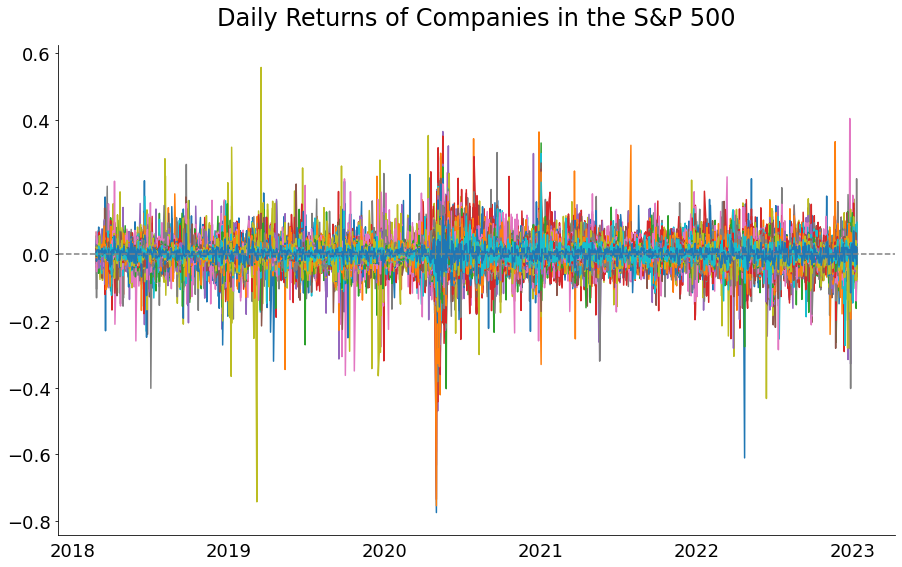

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(15,10)) 

logRet.plot(ax=ax,legend=False)  # We can use pandas for plotting too!
ax.axhline(y=0,linestyle='--',color='gray')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Daily Returns of Companies in the S&P 500',fontsize=24,pad=20)
ax.set_facecolor('white')
plt.xticks(rotation = 0, size=18)
ax.xaxis.set_ticks_position('none')   # Remove the small tick marks
plt.yticks(size=18)
sns.despine(ax=ax)

plt.show()

**Discuss:** This plot shows the log returns across time for the S&P500 stocks. Since there are approximately 500 stocks included in this graph, it is quite difficult to visualize and understand any patterns. It seems like there is more variation in log returns when we approach the end or beginning of a new year. We see the most variation when COVID was in full affect during 2020.

# 3. Principal Components  <font color=brown>[30 Points]</font>

## 3.1 Recover the first principal component of stock returns
For example, 
```python
from sklearn.decomposition import PCA
pca = PCA(1).fit(df.fillna(0))
```
where I used "NaN" to replace values with a zero using `.fillna(0)` and `df` is the log-returns DataFrame. You can find the first principal components for the stocks in `pca.components_[0]`. 

In [4]:
from sklearn.decomposition import PCA
pca = PCA(1).fit(logRet.fillna(0))
pca_first = pd.Series(index=logRet.columns, data=pca.components_[0])
pca_first

A      -0.036743
AAL    -0.069569
AAP    -0.038250
AAPL   -0.041135
ABBV   -0.025576
          ...   
YUM    -0.033279
ZBH    -0.040714
ZBRA   -0.050048
ZION   -0.051847
ZTS    -0.034080
Length: 501, dtype: float64

## 3.2 Plot the first principal component across stocks.

<AxesSubplot:title={'center':'First Principal Component of the S&P500 Stocks'}>

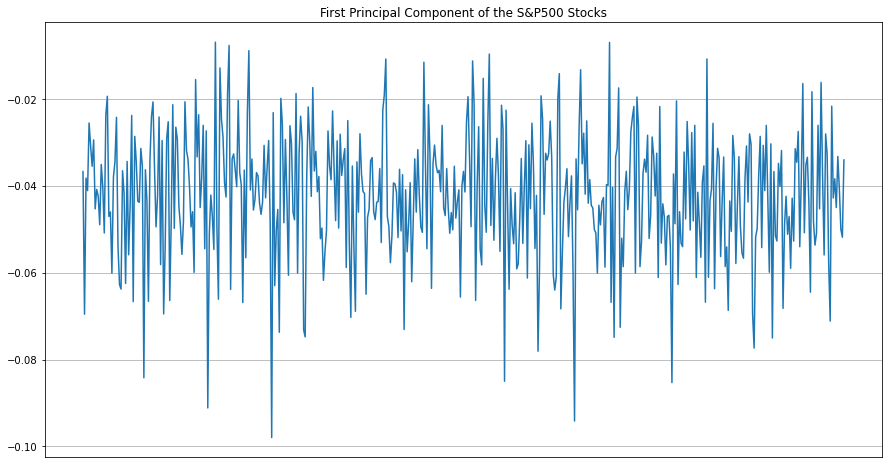

In [5]:
pca_first.plot(xticks=[], grid=True, title='First Principal Component of the S&P500 Stocks', figsize=(15, 8))

## 3.3 Create portfolio weights.

We know that:

* the first principal component represents the linear combination of the input data that explains most of the variance, and

* the primary driver of stock returns is the overall market factor (from CAPM). 

Let's connect these ideas. If we formulate a portfolio of stocks by allocating the cash proportionally to the 1st principal component (i.e. linear combination of the input data), we can replicate the returns of the S&P500 approximately using the primary driver of stock returns.

Construct

$$
\text{weight}_{j}= \frac{\text{"absolute value of the first prinicpal component"}_{j}}{\sum_s\text{"absolute value of the first prinicpal component"}_{s}}
$$

where the numerator is the first principal component for stock $j$ and the deonominator is the sum of first principal components across all of the stocks indexed by $s$.

In [6]:
weights = (abs(pca_first)/sum(abs(pca_first)))
weights

A       0.001739
AAL     0.003293
AAP     0.001811
AAPL    0.001947
ABBV    0.001211
          ...   
YUM     0.001575
ZBH     0.001927
ZBRA    0.002369
ZION    0.002454
ZTS     0.001613
Length: 501, dtype: float64

## 3.4 Construct a stock portfolio by interacting the weights with returns.

Multiply the weights with their corresponding stocks for each period (ie, `df*weights` where `df` is your dataframe of log returns). Sum this up (ie, `(df*weights).sum(1)`) so you have a weighted stock portfolio for each period. You will have to convert log returns back to levels using `np.exp` and then create a cumulative sum across periods (see `.cumsum()` method). Look at the definition of log returns for guidance.

In [7]:
portfolio = (logRet*weights).sum(1)
portfolio = portfolio.cumsum().apply(np.exp)
portfolio

Date
2018-01-02    1.000000
2018-01-03    1.006628
2018-01-04    1.009995
2018-01-05    1.015233
2018-01-08    1.018279
                ...   
2022-11-14    1.467583
2022-11-15    1.483613
2022-11-16    1.461425
2022-11-17    1.452541
2022-11-18    1.461879
Length: 1231, dtype: float64

## 3.5 Visualize your portfolio against the S&P500 index.

Use the yahoo! finance api to download the S&P500 index (ticker: ^GSPC). Create a 2-by-1 figure with your portfolio on top and the S&P500 index on the bottom. Note that in constructing our protfolio based on PCA we implicitly assumed that $log(p_0)=0$ which means that our portfolio is scaled such that $p_0=1$. You should therefore scale the S&P500 index by it's first value so you're comparing apples-to-apples. Discuss the results.

In [8]:
import datetime as dt

start = dt.datetime(2018, 1, 1)
ticker = ['^GSPC']
sp500_gspc = yf.download(ticker, start)['Adj Close']

sp500_gspc = pd.DataFrame(sp500_gspc)
sp500_gspc = sp500_gspc.set_index(pd.to_datetime(sp500_gspc.index.strftime('%Y-%m-%d')))
sp500_gspc

[*********************100%***********************]  1 of 1 completed


,Adj Close
Date,
2018-01-02,2695.810059
2018-01-03,2713.060059
2018-01-04,2723.989990
2018-01-05,2743.149902
2018-01-08,2747.709961
...,...
2022-11-14,3957.250000
2022-11-15,3991.729980
2022-11-16,3958.790039


/var/folders/51/h1nmh05j5mz75s5kwn0ngjxr0000gn/T/ipykernel_53528/3372099042.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  plot_df = pd.concat([portfolio, sp500_gspc.apply(np.log).diff(1).cumsum().apply(np.exp)], 1)


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

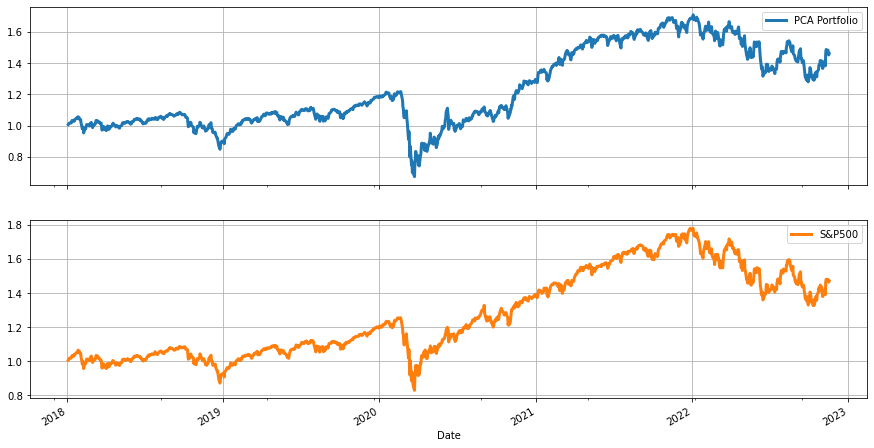

In [9]:
plot_df = pd.concat([portfolio, sp500_gspc.apply(np.log).diff(1).cumsum().apply(np.exp)], 1)
plot_df.columns = ["PCA Portfolio", "S&P500"]
plot_df.dropna().plot(subplots=True, grid=True, figsize=(15,8), linewidth=3)

**Discuss:** After visualizing my portolio (top graph) against the S&P500 index (bottom graph), we can see that the PCA portfolio and S&P500 index almost match from 2018 to present-day. However, my PCA portfolio achieves slightly lower returns scale-wise over time. We see a relatively large dip in the graphs, most likely as a result of COVID being in full effect in March of 2020. Following that dip, returns steadily increase until 2022, where we see a little more variation in returns. 

# 4. Effect of COVID-19 on Firms  <font color=brown>[30 Points]</font>

We can use PCA to identify which businesses were most (least) affected by the COVID19 pandemic. Note that we'll do this without any prior knowledge of their fundamentals. We're just going to group them and look for similarities.

## 4.1 Visualize Stock Performance using PCA

Create a 2-by-1 figure where the top graph is a bar chart with the best performing stocks during COVID-19 and the bottom figure is the ten worst performing stocks during COVID-19. Discuss your results. Do some research to figure out what industries these stocks represent.

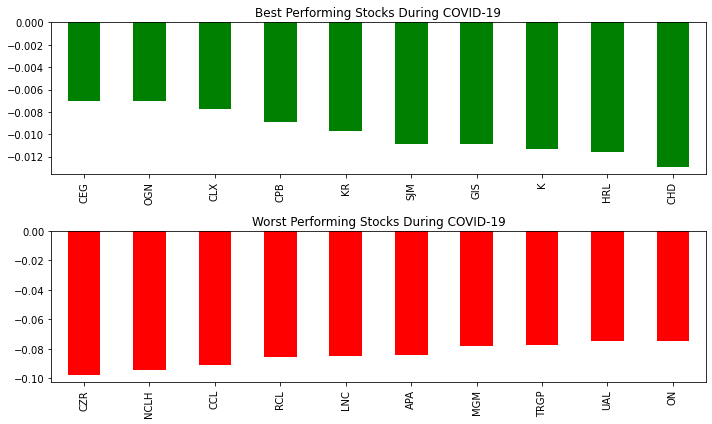

In [10]:
fig, ax = plt.subplots(2,1, figsize=(10, 6))

pca_first.nlargest(10).plot.bar(ax=ax[0], color='green', grid=False, title='Best Performing Stocks During COVID-19')
pca_first.nsmallest(10).plot.bar(ax=ax[1], color='red', grid=False, title='Worst Performing Stocks During COVID-19')
fig.tight_layout()

**Discuss:** After visualizing stock performance using PCA with the best performing stocks in green and worst performing stocks in red, we can see more variation among stocks that performed well during COVID-19 compared to those that did not perform well. The stocks that were positively affected by COVID-19 were the energy, pharmacutical, cleaning, food manufacturing, and housing products industries most likely due to quarantine protocols. On the other hand, casino, cruise, insurance, and airline industries were negatively affected by the pandemic due to the major reduction of travel and in-person events.

## 4.2 Formulate a Winning COVID-19 Portfolio.

Use the top 10 companies according to the PCA weights to create a new portfolio. 

In [11]:
new_portfolio = logRet[pca_first.nlargest(10).index].mean(1)
new_portfolio

Date
2018-01-02         NaN
2018-01-03   -0.008763
2018-01-04    0.007092
2018-01-05    0.004668
2018-01-08    0.007531
                ...   
2022-11-14   -0.001959
2022-11-15    0.003989
2022-11-16    0.007710
2022-11-17   -0.000253
2022-11-18    0.014713
Length: 1231, dtype: float64

## 4.3 Visualize your Portfolio

Create a figure which compares the S&P500 to your portfolio. Discuss the results. 

In [12]:
start = dt.datetime(2018, 1, 1)
ticker = ['^GSPC']
sp500_gspc2 = yf.download(ticker, start)['Adj Close']

sp500_gspc2 = pd.DataFrame(sp500_gspc2)
sp500_gspc2 = sp500_gspc2.set_index(pd.to_datetime(sp500_gspc2.index.strftime('%Y-%m-%d')))

[*********************100%***********************]  1 of 1 completed


/var/folders/51/h1nmh05j5mz75s5kwn0ngjxr0000gn/T/ipykernel_53528/3962526626.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  plot_df2 = pd.concat([new_portfolio.cumsum().apply(np.exp), sp500_gspc2.apply(np.log).diff(1).cumsum().apply(np.exp)], 1)


Text(2020-06-30 00:00:00, 1.7, 'COVID-19 Period')

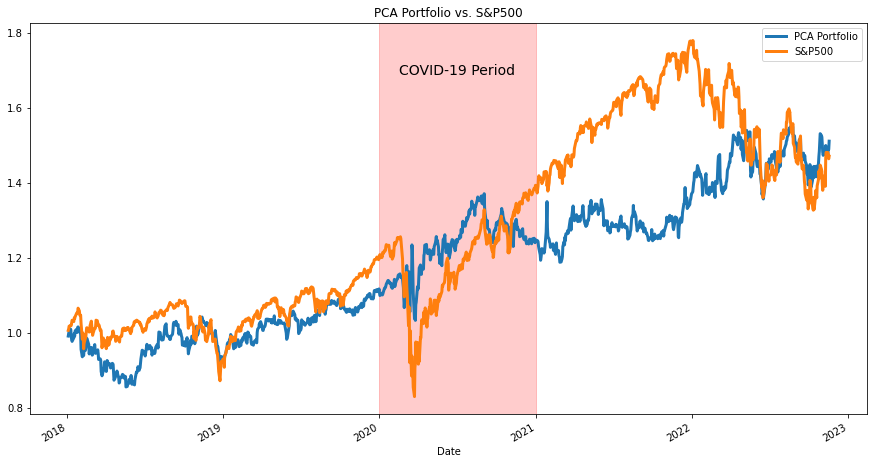

In [24]:
plot_df2 = pd.concat([new_portfolio.cumsum().apply(np.exp), sp500_gspc2.apply(np.log).diff(1).cumsum().apply(np.exp)], 1)
plot_df2.columns = ["PCA Portfolio", "S&P500"]
ax = plot_df2.dropna().plot(figsize=(15,8), grid=False, linewidth=3, title='PCA Portfolio vs. S&P500')
ax.axvspan('2020-01-01','2021-01-01', color = 'red', alpha = 0.2)
ax.annotate('COVID-19 Period',xy=(dt.datetime(2020,6,30),1.7),va='center',ha='center',size=14)

**Discuss:** After creating a new portfolio with the top performing stocks during COVID-19, we see that the portfolio visibily outperforms the S&P500 market index during the COVID-19 period from around March of 2020 to November or December of 2020. If we had used this PCA analysis and invested in these stocks that benefited from the pandemic prior to this period, we may have made a good bit of money. From a more broad view, we see that both lines move in a similar path up until COVID-19 taking full affect in 2020, where the S&P500 takes a massive dip and the new portfolio continues increasing steadily. The S&P500 index overtakes my new portfolio right before 2021 until the middle of the year in 2022. They then continue to match until present day.